<div style="border: 1px solid #444; padding: 20px; border-radius: 5px;">

<h1 style="margin-top: 0;">Overview: The Airbnb AI Consultant</h1>

<h3 style="color: #8a8787;">The Problem</h3>
<p style="font-size: 16px; line-height: 1.6;">
Millions of Airbnb hosts struggle with a key question: "What makes a listing successful?" They often rely on guesswork to write descriptions and choose photos, with no data-driven way to optimize their listing for a 5-star review.
</p>

<h3 style="color: #8a8787;">Our Solution</h3>
<p style="font-size: 16px; line-height: 1.6;">
This project introduces <b>"The Airbnb AI Consultant,"</b> a complete, multimodal AI system built on Google Cloud's powerful tools. Our system analyzes a listing's text, photos, and core data to not only predict its success but to provide actionable, AI-generated advice for improvement.
</p>

<h3 style="color: #8a8787;">The Technical Journey</h3>
<ol style="font-size: 16px; line-height: 1.6;">
    <li><b>Exploratory Data Analysis (EDA):</b> We start with a raw dataset of ~45,000 Los Angeles listings to uncover key insights.</li>
    <li><b>Multimodal Feature Engineering:</b> We use the <b>Google Vision API</b> to analyze listing photos and advanced NLP techniques to process text descriptions, creating over 800 predictive features.</li>
    <li><b>Predictive Modeling:</b> We iteratively train and evaluate a classification model to predict whether a listing will achieve "Top Tier" status.</li>
    <li><b>Generative AI:</b> We use our model's key findings as a data-driven input for a <b>Generative AI (Google's Gemini model)</b> to create the final "AI Scorecard" with personalized, expert suggestions for hosts.</li>
</ol>
<hr style="border: 1px solid #333;">
<h3 style="color: #8a8787;">Project Assets</h3>
<p style="font-size: 16px; text-align: center;">
    <a href="YOUR_GITHUB_REPO_LINK_HERE" style="text-decoration: none; color: #5B99E5; margin: 0 15px;"><b>GitHub Repository</b></a> |
    <a href="YOUR_LINKEDIN_POST_LINK_HERE" style="text-decoration: none; color: #5B99E5; margin: 0 15px;"><b>LinkedIn Post</b></a> |
    <a href="YOUR_MEDIUM_BLOG_LINK_HERE" style="text-decoration: none; color: #5B99E5; margin: 0 15px;"><b>Medium Blog</b></a> |
    <a href="YOUR_YOUTUBE_VIDEO_LINK_HERE" style="text-decoration: none; color: #5B99E5; margin: 0 15px;"><b>YouTube Demo</b></a>
</p>
</div>

<h2 style="margin-top: 0; border-bottom: 2px solid #555; padding-bottom: 10px;">Table of Contents</h2>
<div style="border: 1px solid #444; padding: 15px; border-radius: 5px;">
    <ul style="list-style-type: none; padding-left: 0;">
        <li style="margin-bottom: 10px; font-size: 16px;"><a href="#Phase-1:-Exploratory-Data-Analysis-(EDA)" style="text-decoration: none; color: #5B99E5;"><b>Phase 1:</b> Exploratory Data Analysis (EDA) & Cleaning</a></li>
        <li style="margin-bottom: 10px; font-size: 16px;"><a href="#Phase-2:-Computer-Vision-Analysis-with-Google-Vision-API" style="text-decoration: none; color: #5B99E5;"><b>Phase 2:</b> Computer Vision Analysis</a></li>
        <li style="margin-bottom: 10px; font-size: 16px;"><a href="#Phase-3:-Predictive-Modeling-(The-BRAIN)" style="text-decoration: none; color: #5B99E5;"><b>Phase 3:</b> Predictive Modeling</a></li>
        <li style="margin-bottom: 10px; font-size: 16px;"><a href="#Phase-4:-Insight-Generation-&-The-AI-Scorecard" style="text-decoration: none; color: #5B99E5;"><b>Phase 4:</b> Insight Generation & The AI Scorecard</a></li>
        <li style="margin-bottom: 10px; font-size: 16px;"><a href="#Phase-5:-Conclusion-&-Future-Work" style="text-decoration: none; color: #5B99E5;"><b>Phase 5:</b> Conclusion & Future Work</a></li>
        <li style="margin-top: 20px; font-size: 16px; border-top: 1px solid #444; padding-top: 10px;"><a href="#Appendix:-Other-Experiments." style="text-decoration: none; color: #999;"><i>Appendix: Other Model Experiments</i></a></li>
    </ul>
</div>

## Architecture Diagram
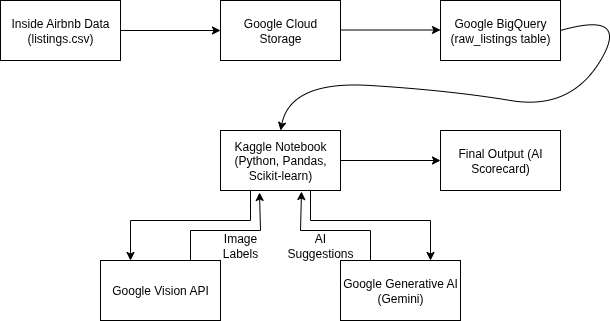

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import time
import warnings

from google.cloud import bigquery
from google.cloud import storage
from google.cloud import vision
from google.api_core.client_options import ClientOptions

from kaggle_secrets import UserSecretsClient

from tqdm.auto import tqdm
import ast 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from scipy.stats import uniform, randint

import xgboost as xgb

from tqdm.notebook import tqdm

# Import VADER
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk


In [3]:
# Ignore harmless warnings to keep the notebook clean
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
project_id = 'bq-hackathon-ab-123'
client = bigquery.Client(project=project_id)
print(f"Successfully connected to BigQuery project: {project_id}")

Successfully connected to BigQuery project: bq-hackathon-ab-123


In [5]:
# Define the SQL query to select all data from our table
sql = """
    SELECT *
    FROM `bq-hackathon-ab-123.airbnb_analysis.raw_listings`
"""

In [6]:
# Run the query and load the results into a Pandas DataFrame
print("Running query to load data...")
df = client.query(sql).to_dataframe()

Running query to load data...


In [7]:
# Verify the data loaded correctly
print("\nData loaded successfully from BigQuery!")


Data loaded successfully from BigQuery!


# Phase 1: Exploratory Data Analysis (EDA)

Our first step is to perform a thorough Exploratory Data Analysis (EDA) to understand the structure, quality, and characteristics of our dataset.

### Goal
The first step in any EDA is to perform a high-level "health check" on the dataset. We're not looking for deep insights yet. Instead, we want to understand the basic structure and identify any immediate, glaring issues. We will check:
*   **Dimensions:** How big is the dataset (rows and columns)?
*   **Data Types:** Are columns stored in the correct format (e.g., numbers as `int`/`float`, text as `object`)?
*   **Missing Values:** Get a first glance at the scale of the null value problem.
*   **Duplicates:** Check for any completely duplicated entries.

In [8]:
# --- Step 1: The First Contact ---

# 1. Check the dimensions of the DataFrame (rows, columns)
print(f"Dataset Shape: {df.shape}")

Dataset Shape: (45421, 79)


In [9]:
# 2. Display the first 5 rows to get a feel for the data
print("\n--- First 5 Rows ---")
display(df.head())


--- First 5 Rows ---


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,10034835,https://www.airbnb.com/rooms/10034835,20250617032927,2025-06-17,previous scrape,Large private bedroom in Palms,Cozy private bedroom in a 2 Bedroom/2Bathroom ...,None,https://a0.muscache.com/pictures/03b70113-c47f...,23571738,...,NaN,NaN,NaN,None,False,1,0,1,0,NaN
1,6900415,https://www.airbnb.com/rooms/6900415,20250617032927,2025-06-17,previous scrape,"Quiet, Cozy West LA House","A beautiful, quiet little house with a great b...",Walking distance to coffee shops and restauran...,https://a0.muscache.com/pictures/87362346/ebd8...,36159573,...,NaN,NaN,NaN,None,False,1,1,0,0,NaN
2,579654200712117931,https://www.airbnb.com/rooms/579654200712117931,20250617032927,2025-06-17,city scrape,Luxurious Room for Rent in New Large Home w/Spa,Leave your stress behind as you enter Hawaii m...,None,https://a0.muscache.com/pictures/miso/Hosting-...,41729773,...,5.00,5.00,5.00,HSR24-002211,False,2,1,1,0,1.00
3,578992356337858832,https://www.airbnb.com/rooms/578992356337858832,20250617032927,2025-06-17,city scrape,Luxurious Home & Infinity Spa 3bdrm,Brand new luxury home built in 2019 in San Fer...,None,https://a0.muscache.com/pictures/miso/Hosting-...,41729773,...,4.83,4.83,4.83,HSR24-002211,True,2,1,1,0,0.71
4,1349320047388947928,https://www.airbnb.com/rooms/1349320047388947928,20250617032927,2025-06-17,city scrape,1 bedroom w/ full size bathroom,Welcome to our cozy shared space! You'll have ...,None,https://a0.muscache.com/pictures/miso/Hosting-...,185374617,...,5.00,5.00,4.67,None,False,2,0,2,0,0.76


In [10]:
# 3. Display the last 5 rows to check for any summary rows or weird data at the end
print("\n--- Last 5 Rows ---")
display(df.tail())


--- Last 5 Rows ---


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
45416,1443665272616764114,https://www.airbnb.com/rooms/1443665272616764114,20250617032927,2025-06-17,city scrape,Newly listed charming room.,Sunny SoCal Retreat-<br />This comfortable pri...,None,https://a0.muscache.com/pictures/hosting/Hosti...,701308195,...,NaN,NaN,NaN,None,False,2,0,2,0,NaN
45417,1443686653547958284,https://www.airbnb.com/rooms/1443686653547958284,20250617032927,2025-06-17,city scrape,Newly Listed Master Bedroom.,Charming Glendora Master Suite — Comfort & Con...,None,https://a0.muscache.com/pictures/hosting/Hosti...,701308195,...,NaN,NaN,NaN,None,False,2,0,2,0,NaN
45418,1444587428214147243,https://www.airbnb.com/rooms/1444587428214147243,20250617032927,2025-06-18,city scrape,LA.Affordable Stay Steps from USC|DTLA|Dodger,Thank you for considering our home for your se...,None,https://a0.muscache.com/pictures/miso/Hosting-...,701545457,...,NaN,NaN,NaN,None,False,3,0,3,0,NaN
45419,1444598206634973705,https://www.airbnb.com/rooms/1444598206634973705,20250617032927,2025-06-18,city scrape,LC.Affordable Stay Steps from USC|DTLA|Dodger,Thank you for considering our home for your se...,None,https://a0.muscache.com/pictures/miso/Hosting-...,701545457,...,NaN,NaN,NaN,None,False,3,0,3,0,NaN
45420,1444599090492474371,https://www.airbnb.com/rooms/1444599090492474371,20250617032927,2025-06-18,city scrape,LD.Affordable Stay Steps from USC|DTLA|Dodger,Thank you for considering our home for your se...,None,https://a0.muscache.com/pictures/miso/Hosting-...,701545457,...,NaN,NaN,NaN,None,False,3,0,3,0,NaN


In [11]:
# 4. Get the concise summary of the DataFrame. This is the most critical part of this step!
# It tells us column names, non-null counts, and data types (Dtype).
print("\n--- DataFrame Info ---")
# Using verbose=True to ensure all columns are shown, even if there are many
df.info(verbose=True, show_counts=True)


--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45421 entries, 0 to 45420
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            45421 non-null  Int64  
 1   listing_url                                   45421 non-null  object 
 2   scrape_id                                     45421 non-null  Int64  
 3   last_scraped                                  45421 non-null  dbdate 
 4   source                                        45421 non-null  object 
 5   name                                          45421 non-null  object 
 6   description                                   44399 non-null  object 
 7   neighborhood_overview                         20351 non-null  object 
 8   picture_url                                   45421 non-null  object 
 9   host_id                              

In [12]:
# 5. Check for any completely duplicate rows
print(f"\n--- Duplicate Rows ---")
print(f"Number of completely duplicate rows: {df.duplicated().sum()}")


--- Duplicate Rows ---
Number of completely duplicate rows: 0


In [13]:
print("\n--- Summary Statistics for Numerical Columns ---")
df.describe()


--- Summary Statistics for Numerical Columns ---


,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,45421.0,45421.0,45421.0,45414.0,45414.0,45421.000000,45421.000000,45421.0,36588.000000,42358.0,...,32841.000000,32833.000000,32839.000000,32832.000000,32831.000000,45421.0,45421.0,45421.0,45421.0,32849.000000
mean,649078173423668480.0,20250617032927.0,213770803.998327,120.426983,168.288722,34.055275,-118.309934,4.050461,1.653766,1.803673,...,4.748009,4.853984,4.854049,4.791058,4.706046,20.535897,16.280817,3.366306,0.192532,1.363129
std,569486779305695552.0,0.0,210793650.013248,670.154114,876.674501,0.144776,0.173013,2.87731,1.208846,1.317982,...,0.446472,0.382428,0.393493,0.396185,0.457817,71.83698,70.134005,13.692049,2.104227,1.748087
min,2708.0,20250617032927.0,767.0,0.0,0.0,33.338540,-118.917134,1.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.010000
25%,37149372.0,20250617032927.0,28483717.0,1.0,2.0,33.998240,-118.411370,2.0,1.000000,1.0,...,4.690000,4.860000,4.870000,4.750000,4.650000,1.0,1.0,0.0,0.0,0.200000
50%,770336981567614848.0,20250617032927.0,124925839.0,3.0,5.0,34.061650,-118.340640,3.0,1.000000,1.0,...,4.880000,4.970000,4.980000,4.910000,4.820000,2.0,1.0,0.0,0.0,0.700000
75%,1199335788049644032.0,20250617032927.0,404254876.0,13.0,20.0,34.108380,-118.224403,6.0,2.000000,2.0,...,5.000000,5.000000,5.000000,5.000000,4.970000,10.0,6.0,1.0,0.0,2.020000
max,1444599090492474368.0,20250617032927.0,701545457.0,4925.0,9109.0,34.811180,-117.654300,16.0,32.500000,24.0,...,5.000000,5.000000,5.070000,5.000000,5.000000,599.0,599.0,133.0,38.0,74.260000


## 1.1 Initial Inspection

*   **Dataset Shape:** The dataset is quite large and complex, with **45,421 rows** and **79 columns**. This indicates we have a rich set of features to explore, but we'll also need to be mindful of computational efficiency.

*   **Target Variable:** The primary target variable for our prediction goal is `review_scores_rating`. We can see it's a `float64` type, which is appropriate. However, it has a significant number of missing values (only 32,849 non-null out of 45,421). This is a critical issue we'll need to address.

*   **Key Issues Identified:**
    *   **Massive Missing Values:** Several columns are almost unusable or require significant imputation.
        *   `calendar_updated` is **100% null** and can be dropped immediately.
        *   `license` is mostly null (only 12,882 non-null).
        *   `neighborhood_overview`, `neighbourhood`, `host_about` are all less than 50% filled. This suggests they might be difficult to use reliably.
        *   Many core features like `beds`, `bedrooms`, `bathrooms`, and `price` also have thousands of missing values.
    *   **Data Type Mismatches:** These are critical cleaning tasks.
        *   `price` is an `object` type, likely due to currency symbols (e.g., '$') and commas. It must be converted to a numeric type (`float`) to be used in modeling.
        *   Date columns like `last_scraped`, `host_since`, `first_review`, and `last_review` are stored as `object`. They need to be converted to `datetime` objects to extract useful features like seasonality or host tenure.
        *   Percentage columns like `host_response_rate` and `host_acceptance_rate` are `object`s, likely due to '%' signs. They need to be converted to numeric types.
    *   **Duplicates:** There are **0 completely duplicate rows**, which is good news. However, we might still have duplicate *listings* based on `id` if the data was scraped multiple times, which we can investigate later.

## 1.2 Core Feature Selection

To make our analysis more manageable and focused, we select a subset of 13 "golden" columns that are most relevant to our project goal. This includes identifiers, descriptive text and images, key property features, price, and our target variable, the review score.

By examining the non-null counts for this subset, we can formulate a clear cleaning strategy:

*   **Inputs:** Our core inputs, `description` and `picture_url`, are largely complete.
*   **Target:** Our target variable, `review_scores_rating`, is missing for ~28% of listings.
*   **Key Features:** `price` is missing for ~20% of listings, and other features like `beds` and `bedrooms` also have significant gaps.

**Conclusion:** Any row missing the `review_scores_rating`, `price`, or `description` will be excluded from our final model training dataset, as these are essential for our analysis.

In [14]:
golden_columns = [
    'id',
    'name',
    'description',
    'picture_url',
    'host_is_superhost',  
    'room_type',
    'property_type',
    'accommodates',
    'bathrooms_text',
    'bedrooms',
    'beds',
    'amenities',
    'price',
    'review_scores_rating'
]

In [15]:
df_selected = df[golden_columns].copy()

In [16]:
# Verify the new DataFrame
print("--- New DataFrame with Selected 'Golden' Columns ---")
print(f"The new shape is: {df_selected.shape}")
print("\nHere's a look at the first few rows:")
display(df_selected.head())

--- New DataFrame with Selected 'Golden' Columns ---
The new shape is: (45421, 14)

Here's a look at the first few rows:


,id,name,description,picture_url,host_is_superhost,room_type,property_type,accommodates,bathrooms_text,bedrooms,beds,amenities,price,review_scores_rating
0,10034835,Large private bedroom in Palms,Cozy private bedroom in a 2 Bedroom/2Bathroom ...,https://a0.muscache.com/pictures/03b70113-c47f...,False,Private room,Private room in rental unit,3,1 bath,<NA>,<NA>,"[""TV"", ""Heating"", ""Washer"", ""Carbon monoxide a...",<NA>,NaN
1,6900415,"Quiet, Cozy West LA House","A beautiful, quiet little house with a great b...",https://a0.muscache.com/pictures/87362346/ebd8...,False,Entire home/apt,Entire home,3,1 bath,1,<NA>,"[""Pets allowed"", ""Washer"", ""First aid kit"", ""F...",<NA>,NaN
2,579654200712117931,Luxurious Room for Rent in New Large Home w/Spa,Leave your stress behind as you enter Hawaii m...,https://a0.muscache.com/pictures/miso/Hosting-...,False,Private room,Private room in home,1,1 private bath,1,1,"[""TV"", ""BBQ grill"", ""Smoking allowed"", ""Washer...",136,5.00
3,578992356337858832,Luxurious Home & Infinity Spa 3bdrm,Brand new luxury home built in 2019 in San Fer...,https://a0.muscache.com/pictures/miso/Hosting-...,False,Entire home/apt,Entire home,8,3 baths,4,3,"[""Stove"", ""Extra pillows and blankets"", ""Coffe...",413,4.83
4,1349320047388947928,1 bedroom w/ full size bathroom,Welcome to our cozy shared space! You'll have ...,https://a0.muscache.com/pictures/miso/Hosting-...,<NA>,Private room,Private room in home,2,1.5 baths,1,1,"[""Carbon monoxide alarm"", ""Washer"", ""Lock on b...",58,5.00


In [17]:
# n updated .info() to see the non-null counts for just these columns.
print("\n--- Updated Info for Selected Columns ---")
df_selected.info()


--- Updated Info for Selected Columns ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45421 entries, 0 to 45420
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    45421 non-null  Int64  
 1   name                  45421 non-null  object 
 2   description           44399 non-null  object 
 3   picture_url           45421 non-null  object 
 4   host_is_superhost     43852 non-null  boolean
 5   room_type             45421 non-null  object 
 6   property_type         45421 non-null  object 
 7   accommodates          45421 non-null  Int64  
 8   bathrooms_text        45367 non-null  object 
 9   bedrooms              42358 non-null  Int64  
 10  beds                  36545 non-null  Int64  
 11  amenities             45421 non-null  object 
 12  price                 36405 non-null  Int64  
 13  review_scores_rating  32849 non-null  float64
dtypes: Int64(5), boolean(1), fl

## 1.3 Data Cleaning & Quality Control

With our core features selected, we proceed with cleaning the data to create a high-quality dataset for modeling.

In [18]:
# Making a copy
df_cleaning = df_selected.copy()

### 1.3.1 Handling Missing Values
Our primary cleaning step is to remove any listings that are missing essential information. We filter the dataset, keeping only the rows that have a valid `review_scores_rating`, `description`, AND `price`. This aggressive but necessary step reduces our dataset to **26,589 high-quality, complete entries**, retaining approximately 59% of the original data.

In [19]:
# Handle Missing Values
# We will drop any rows where our essential columns are empty.
# These are 'review_scores_rating', 'description', and 'price'.
initial_rows = len(df_cleaning)
df_cleaning.dropna(subset=['review_scores_rating', 'description', 'price'], inplace=True)
final_rows = len(df_cleaning)

In [20]:
print("--- 1. Handling Missing Values ---")
print(f"Initial number of rows: {initial_rows}")
print(f"Number of rows after dropping essential NaNs: {final_rows}")
print(f"Number of rows removed: {initial_rows - final_rows}")
print(f"Percentage of data retained: {100 * final_rows / initial_rows:.2f}%")

--- 1. Handling Missing Values ---
Initial number of rows: 45421
Number of rows after dropping essential NaNs: 26589
Number of rows removed: 18832
Percentage of data retained: 58.54%


### 1.3.2 Checking for Duplicates
A check for duplicate `id` values confirms that there are **no duplicate listings** in our dataset.

In [21]:
# Check for Duplicates
initial_rows = len(df_cleaning)
df_cleaning.drop_duplicates(subset=['id'], inplace=True)
final_rows = len(df_cleaning)

In [22]:
print("\n--- Checking for Duplicates ---")
if initial_rows == final_rows:
    print("No duplicate listing IDs found. Good!")
else:
    print(f"Removed {initial_rows - final_rows} duplicate rows.")


--- Checking for Duplicates ---
No duplicate listing IDs found. Good!


### 1.3.3 Correcting Data Types
The `price` column was converted from a text object (e.g., "$110.00") to a numerical `float` type, which is essential for any statistical analysis or modeling.

The result of this phase is a new DataFrame, `df_clean`, where our most critical columns are 100% complete and correctly formatted.

In [23]:
# Correct Data Types for 'price'
# The 'price' column is an object (text) due to '$' and ','.
# We need to remove these characters and convert it to a float.
print("\n--- Correcting 'price' Data Type ---")
print(f"Original 'price' Dtype: {df_cleaning['price'].dtype}")


--- Correcting 'price' Data Type ---
Original 'price' Dtype: Int64


In [24]:
# This line uses string operations to remove '$' and ',' then converts to a numeric type
df_cleaning['price'] = df_cleaning['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)

In [25]:
print(f"New 'price' Dtype: {df_cleaning['price'].dtype}")
print("First 5 price values after cleaning:")
print(df_cleaning['price'].head())

New 'price' Dtype: float64
First 5 price values after cleaning:
2    136.0
3    413.0
4     58.0
5     51.0
6     96.0
Name: price, dtype: float64


In [26]:
# --- Final Cleaned DataFrame ---
# Let's assign this to a final, clean name for the rest of the project.
df_clean = df_cleaning.copy()

In [27]:
print("\n--- Final Cleaned DataFrame Info ---")
df_clean.info()


--- Final Cleaned DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 26589 entries, 2 to 45412
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    26589 non-null  Int64  
 1   name                  26589 non-null  object 
 2   description           26589 non-null  object 
 3   picture_url           26589 non-null  object 
 4   host_is_superhost     25489 non-null  boolean
 5   room_type             26589 non-null  object 
 6   property_type         26589 non-null  object 
 7   accommodates          26589 non-null  Int64  
 8   bathrooms_text        26576 non-null  object 
 9   bedrooms              26557 non-null  Int64  
 10  beds                  26569 non-null  Int64  
 11  amenities             26589 non-null  object 
 12  price                 26589 non-null  float64
 13  review_scores_rating  26589 non-null  float64
dtypes: Int64(4), boolean(1), float64(2), 

## 1.4 Visualizing Key Numerical Features

To understand the characteristics of our listings, we visualize the distributions of our most important numerical columns: `review_scores_rating` and `price`.

In [28]:
# Set the style for our plots for a professional look
sns.set_style('whitegrid')

### 1.4.1 Review Scores Distribution
The distribution of review scores is heavily **left-skewed**, with a massive peak at the maximum rating of 5.0. This is typical for review data and indicates that most listings are highly rated. Our model's main challenge will be to identify the specific factors that differentiate a perfect 5.0 listing from a good (but not perfect) one.

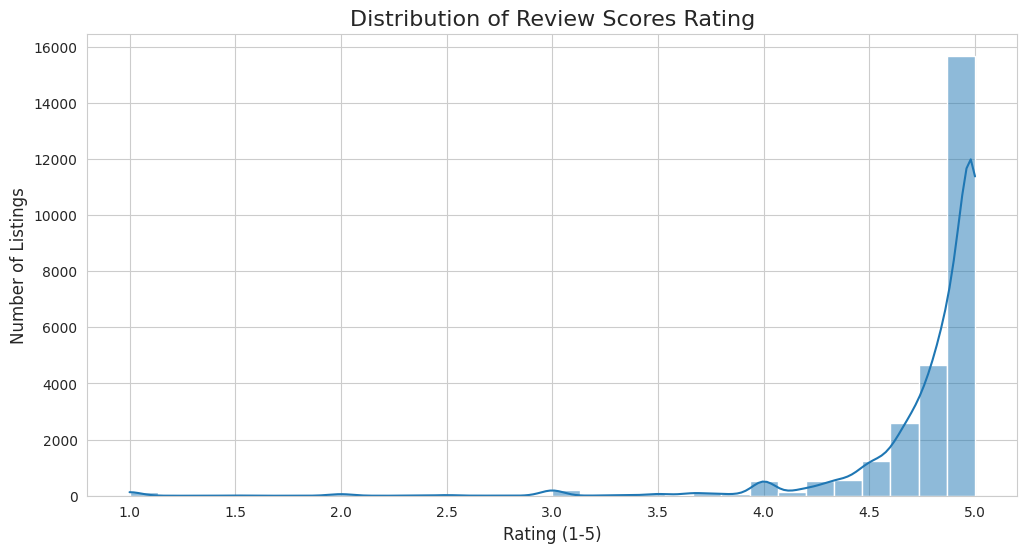

In [29]:
# Distribution of Review Scores
plt.figure(figsize=(12, 6))
sns.histplot(df_clean['review_scores_rating'], bins=30, kde=True)
plt.title('Distribution of Review Scores Rating', fontsize=16)
plt.xlabel('Rating (1-5)', fontsize=12)
plt.ylabel('Number of Listings', fontsize=12)
plt.show()

### 1.4.2 Price Distribution & Outliers
The distribution of price is heavily **right-skewed**, with the vast majority of listings priced under $500 per night. A small number of extremely expensive listings (outliers) stretch the distribution.

**Actionable Insight:** These extreme price outliers can negatively impact model performance. We will later filter our dataset to focus on a more conventional price range (e.g., below the 99th percentile) to build a more robust and accurate model.

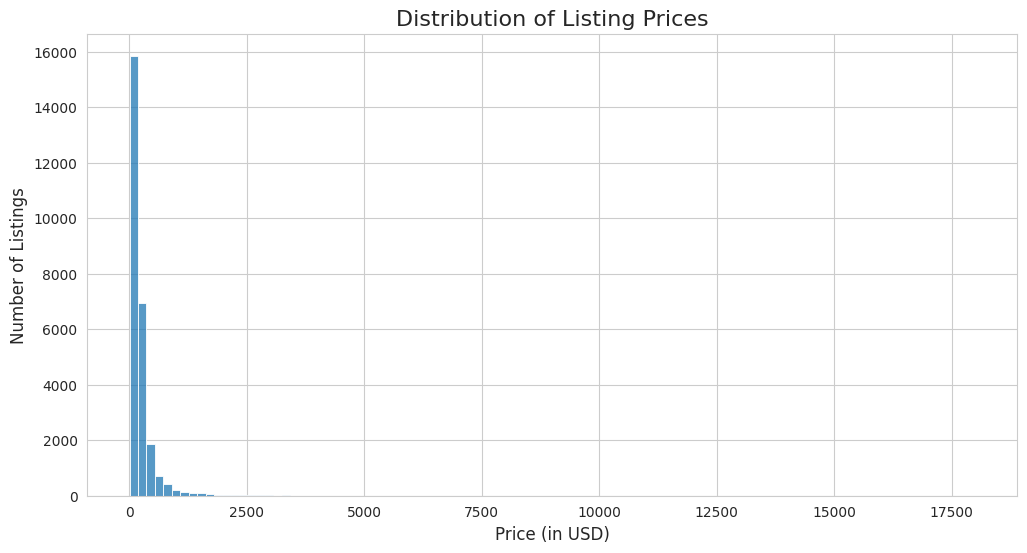

In [30]:
# Distribution of Price (Checking for Outliers)
plt.figure(figsize=(12, 6))
sns.histplot(df_clean['price'], bins=100, kde=False) # kde=False as the long tail is extreme
plt.title('Distribution of Listing Prices', fontsize=16)
plt.xlabel('Price (in USD)', fontsize=12)
plt.ylabel('Number of Listings', fontsize=12)
plt.show()

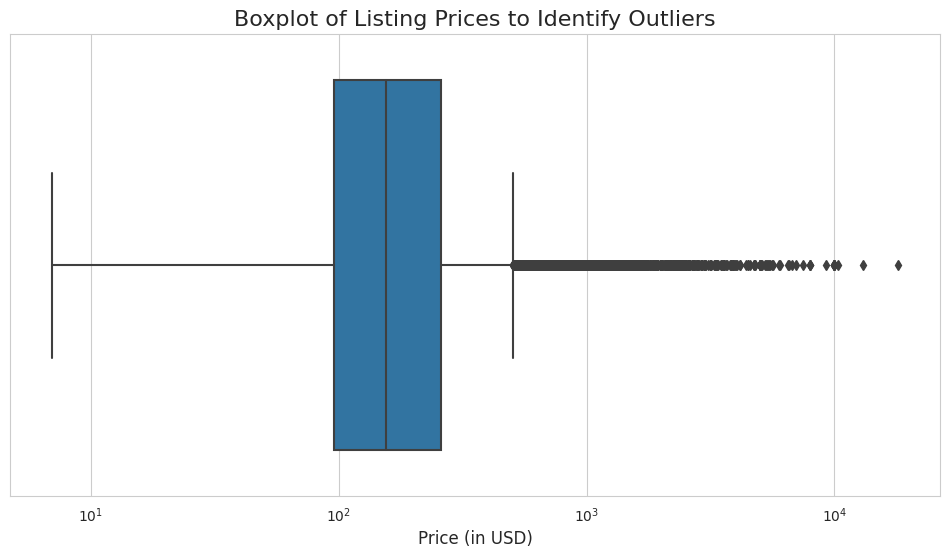

In [31]:
# Let's also look at a boxplot for price to better see the outliers
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_clean['price'])
plt.title('Boxplot of Listing Prices to Identify Outliers', fontsize=16)
plt.xlabel('Price (in USD)', fontsize=12)
plt.xscale('log') # Use a log scale to better visualize the wide range of prices
plt.show()

## 1.5 Analyzing Categorical Features: Room Type

We next explore the `room_type` of the listings to understand the dataset's composition and its relationship with review scores.

### 1.5.1 Composition
The count plot reveals that the dataset is dominated by **"Entire home/apt"** and **"Private room"** listings. "Shared room" and "Hotel room" are far less common. This means our model will have a much richer set of data to learn from for the two most common categories.

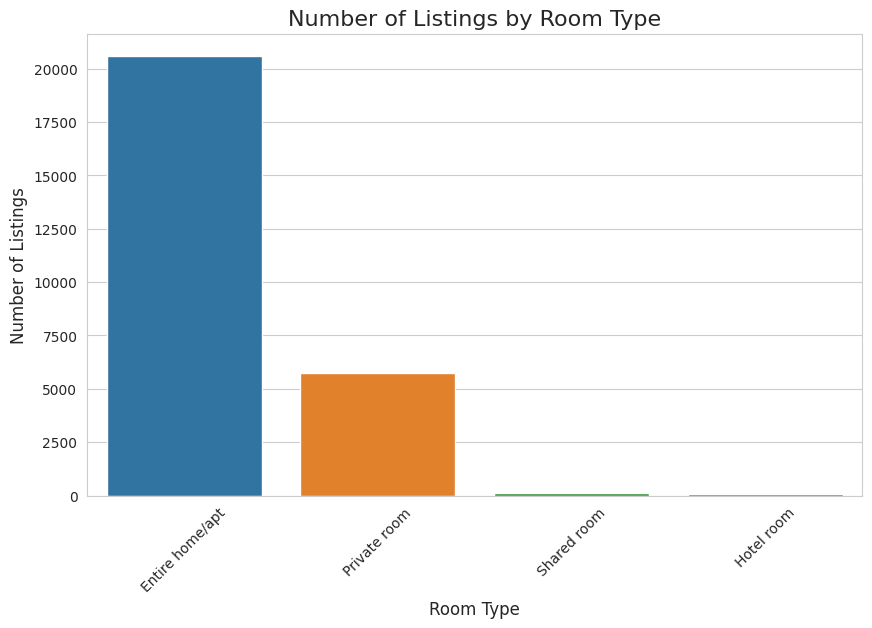

In [32]:
# Composition of Room Types
plt.figure(figsize=(10, 6))
sns.countplot(x='room_type', data=df_clean, order=df_clean['room_type'].value_counts().index)
plt.title('Number of Listings by Room Type', fontsize=16)
plt.xlabel('Room Type', fontsize=12)
plt.ylabel('Number of Listings', fontsize=12)
plt.xticks(rotation=45)
plt.show()

### 1.5.2 Ratings by Room Type
A box plot of review scores for each room type reveals a key insight. While all room types have a very high median rating (close to 5.0), there are subtle but important differences in their distributions.

**Key Insight:** The distribution for **"Shared room" listings is noticeably lower** than for "Entire home/apt" or "Private room". This suggests that while a typical shared room is well-rated, they have a higher tendency to receive scores in the 4.0-4.5 range, making it a more challenging category in which to achieve a perfect rating. This is a valuable feature for our future model.

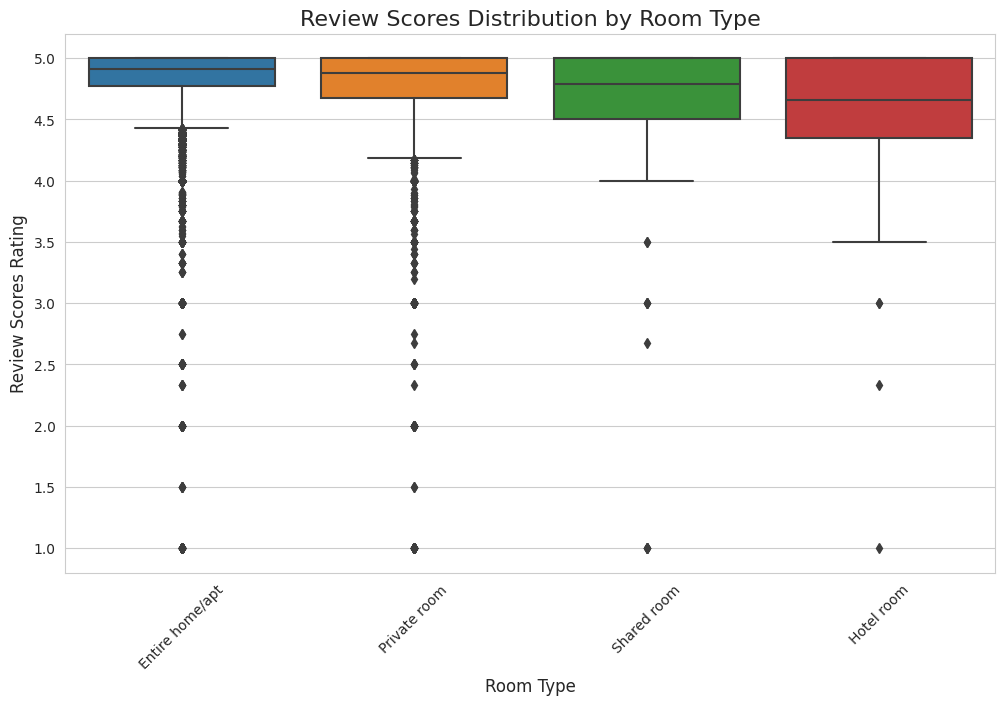

In [33]:
# Review Scores by Room Type
plt.figure(figsize=(12, 7))
sns.boxplot(x='room_type', y='review_scores_rating', data=df_clean, order=df_clean['room_type'].value_counts().index)
plt.title('Review Scores Distribution by Room Type', fontsize=16)
plt.xlabel('Room Type', fontsize=12)
plt.ylabel('Review Scores Rating', fontsize=12)
plt.xticks(rotation=45)
plt.show()

## 1.6 Analyzing Numerical Relationships with a Correlation Matrix

To conclude our EDA, we create a correlation matrix to quantify the relationships between our key numerical features and the `review_scores_rating`.

The resulting heatmap reveals our most significant finding of the entire exploratory analysis:

**Key Insight: Numerical features have almost no correlation with review scores.**

All of the numerical variables, including `price`, `accommodates`, `bedrooms`, and `beds`, show a correlation coefficient of close to zero (≤ 0.05) with the `review_scores_rating`. This is a powerful conclusion:

*   **Price is not a predictor of quality:** More expensive listings do not receive higher ratings.
*   **Size is not a predictor of quality:** Larger listings that accommodate more people or have more bedrooms do not receive higher ratings.

**Conclusion of EDA:** This lack of correlation in the structured, numerical data strongly supports our project's core hypothesis. The factors that truly drive a 5-star guest experience are not captured by simple numbers. Instead, they are likely hidden within the unstructured data: the quality of the host's description, the amenities they offer, and the features visible in their listing photos. This provides a clear mandate for our multimodal approach, leveraging NLP and Computer Vision to unlock these deeper insights.

In [34]:
# Selecting only the most relevant numerical columns for the heatmap
numerical_cols_for_corr = [
    'review_scores_rating',
    'price',
    'accommodates',
    'bedrooms',
    'beds'
]

In [35]:
# Calculate the correlation matrix
correlation_matrix = df_clean[numerical_cols_for_corr].corr()

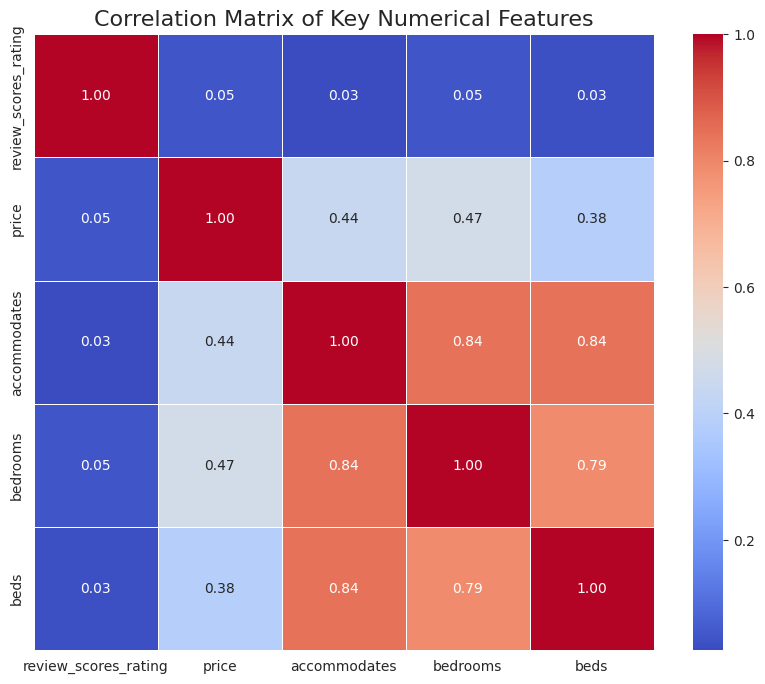

In [36]:
# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Key Numerical Features', fontsize=16)
plt.show()

## 1.7 Data Verification

Before proceeding to analysis, a crucial step is to verify the integrity of our data. We randomly sampled 5 listings and compared the `picture_url` from our dataset with the actual listing on the Airbnb website.

**Findings:**
*   The `picture_url` in our dataset consistently and accurately points to the **main "hero" image** for each listing. The data is reliable.
*   As expected, our dataset only contains this single main image, not the full gallery of photos for each listing.

**Strategic Implication:** This confirms our Computer Vision analysis will be focused on a powerful and relevant question: **"What key feature is the host choosing to highlight in their single most important marketing photo, and how does that choice impact their review score?"** This provides a clear and achievable scope for our CV task.

In [37]:
# --- Verify a few random image URLs ---

# Get 5 random listings from our clean DataFrame
random_samples = df_clean.sample(5)

In [38]:
# Loop through the random samples and print their info
for index, row in random_samples.iterrows():
    print("-" * 50)
    print(f"Listing Name: {row['name']}")
    print(f"Listing ID: {row['id']}")
    print(f"Image URL: {row['picture_url']}")
    print(f"Airbnb Listing URL: https://www.airbnb.com/rooms/{row['id']}")
    print("-" * 50)
    print("\n")

--------------------------------------------------
Listing Name: LARGE PRIVATE BED & BATH - BEVERLY HILLS
Listing ID: 9159345
Image URL: https://a0.muscache.com/pictures/hosting/Hosting-9159345/original/fcb54299-35a9-4edd-92fe-2c148138c247.jpeg
Airbnb Listing URL: https://www.airbnb.com/rooms/9159345
--------------------------------------------------


--------------------------------------------------
Listing Name: Spacious 2 bdrm Spanish-Style in Alamitos Beach 🌼
Listing ID: 43156530
Image URL: https://a0.muscache.com/pictures/miso/Hosting-43156530/original/6f9c9453-d49f-4ffd-9ba5-430ec8a1a342.jpeg
Airbnb Listing URL: https://www.airbnb.com/rooms/43156530
--------------------------------------------------


--------------------------------------------------
Listing Name: Pool HM/RM HotTub/Views, NEW BEACH Industrial Vibe
Listing ID: 41796307
Image URL: https://a0.muscache.com/pictures/miso/Hosting-41796307/original/e6644977-cdaa-4d88-a85f-18691e969b5f.jpeg
Airbnb Listing URL: https:/

## 1.8 Saving the Cleaned Data to BigQuery

To finalize our data preparation phase, we will save our cleaned DataFrame (`df_clean`) back to Google BigQuery as a new table. This provides a clean, persistent starting point for all our future modeling and analysis work.

In [39]:
# Define the full table ID for our new table
# Format is: project_id.dataset_id.table_name
table_id = f"{project_id}.airbnb_analysis.cleaned_listings"

In [40]:
# Configure the job to write the DataFrame to BigQuery
# write_disposition='WRITE_TRUNCATE' means if the table already exists, overwrite it.
job_config = bigquery.LoadJobConfig(
    write_disposition="WRITE_TRUNCATE",
)

In [41]:
# This sends our pandas DataFrame 'df_clean' to be saved as the table specified by 'table_id'.
job = client.load_table_from_dataframe(
    df_clean, table_id, job_config=job_config
)

In [42]:
# Wait for the job to complete and print the result
job.result()  # Waits for the job to finish
print(f"Successfully saved {len(df_clean)} rows to the table: {table_id}")

Successfully saved 26589 rows to the table: bq-hackathon-ab-123.airbnb_analysis.cleaned_listings


# Phase 2: Computer Vision Analysis with Google Vision API

With our data cleaned, we can now enrich it with insights from our unstructured data. In this phase, we will analyze the main listing image (`picture_url`) to extract key visual features. This is the "Computer Vision" component of our multimodal model.

## 2.1 API Setup and Connection Test

First, we install the necessary library, set up our credentials securely using Kaggle Secrets, and run a test on a sample image to confirm our connection to the Google Vision API is working correctly.

In [43]:
# 1. Install the Google Cloud Vision library
!pip install google-cloud-vision -q

In [44]:
# Get the API key we stored securely in Kaggle Secrets
user_secrets = UserSecretsClient()
api_key = user_secrets.get_secret("GOOGLE_API_KEY")

In [45]:
# Create the client using ONLY the client_options with our API key
# This is the direct and correct way to use an API key.
client_options = ClientOptions(api_key=api_key)
client = vision.ImageAnnotatorClient(client_options=client_options)

print("Vision API client created successfully.")

Vision API client created successfully.


In [46]:
# # (RUN ONCE)
# # Test with a single, reliable image URL
# image_url = "https://a0.muscache.com/pictures/47759803/e70c0f85_original.jpg"
# image = vision.Image()
# image.source.image_uri = image_url

In [47]:
# # (RUN ONCE)
# # Perform label detection on the image
# print(f"\nAnalyzing test image: {image_url}")
# response = client.label_detection(image=image)
# labels = response.label_annotations

In [48]:
# # (RUN ONCE)
# # Print the results
# print("\n--- Labels Detected ---")
# for label in labels:
#     print(f"- {label.description} (Score: {label.score:.2f})")

## 2.2 Creating the Image Analysis Function

Now that our connection is established, we will create a robust Python function to analyze our image URLs. This function will call the Vision API, handle potential errors (like broken image links), and return a clean list of the top 5 most relevant labels for each image.

In [49]:
def get_image_labels(image_url):
    """
    Analyzes an image from a URL using the Google Vision API.

    Args:
        image_url (str): The public URL of the image to analyze.

    Returns:
        list: A list of the top 5 label descriptions, or an empty list if an error occurs.
    """
    # Add a small delay to avoid overwhelming the API
    time.sleep(0.1)

    try:
        image = vision.Image()
        image.source.image_uri = image_url
        response = client.label_detection(image=image)
        
        # Check for errors in the API response itself
        if response.error.message:
            # print(f"Error processing {image_url}: {response.error.message}")
            return []

        # Extract just the description text from the top 5 labels
        labels = [label.description for label in response.label_annotations[:5]]
        return labels

    except Exception as e:
        # Catch any other exceptions (e.g., network errors, broken links)
        # print(f"An exception occurred for {image_url}: {e}")
        return []

In [50]:
# # (RUN ONCE)
# # --- Test the function with a sample URL from our dataset ---
# sample_url = df_clean['picture_url'].iloc[0] # Get the first image URL from our clean data
# print(f"Testing function with URL: {sample_url}")

In [51]:
# # (RUN ONCE)
# labels = get_image_labels(sample_url)
# print("\n--- Labels returned by our function ---")
# print(labels)

## 2.3 Applying the Function to a Data Sample

Analyzing all 26,000 images would take a long time and cost more than our $5 budget, To stay within our budget and time constraints, we will analyze a statistically significant sample of 1,000 listings. We will apply our `get_image_labels` function to each image URL in this sample and store the resulting list of labels in a new column called `image_labels`.

To ensure our project is both unbiased and scalable, we will create a permanent, stratified sample. We will add a new boolean column `is_in_1k_sample` to our main `df_clean` DataFrame. We use stratified sampling to select 1,000 listings and flag them as `True`. This entire DataFrame with the new flag is then saved back to BigQuery. This approach allows us to easily and reproducibly select our initial sample, and provides a clear path to scale our analysis in the future by sampling from the remaining, un-flagged data.

In [52]:
# # --- Create and Save a Permanent Stratified Sample Flag (RUN ONCE) ---

# # Create the new column, default to False
# df_clean['is_in_1k_sample'] = False

# # Get the indices of our desired stratified sample
# # We are just getting the IDs/indices of the rows, not the data itself yet.
# _, sample_indices = train_test_split(
#     df_clean.index,  # We stratify on the index
#     test_size=1000,
#     stratify=df_clean['room_type'],
#     random_state=42
# )

In [53]:
# (RUN ONCE)
# # Set the flag to True for our chosen sample indices
# df_clean.loc[sample_indices, 'is_in_1k_sample'] = True

In [54]:
# (RUN ONCE)
# # Verify the flag was set correctly
# print("--- Verification of the new flag ---")
# print(df_clean['is_in_1k_sample'].value_counts())

In [55]:
# (RUN ONCE)
# # --- Confirm the Stratified Sample is Balanced ---

# # 1. Define our new sample and the full dataset
# flagged_sample = df_clean[df_clean['is_in_1k_sample'] == True]
# full_df = df_clean

# print("--- Final Comparison: Flagged Sample vs. Full Dataset ---")

# # 2. Compare the proportions of 'room_type'
# sample_counts = flagged_sample['room_type'].value_counts(normalize=True).rename('Sample')
# full_counts = full_df['room_type'].value_counts(normalize=True).rename('Full Dataset')

# # Combine into a single DataFrame for plotting and viewing
# comparison_df = pd.concat([sample_counts, full_counts], axis=1) * 100

# # 3. Plot the comparison
# comparison_df.plot(kind='bar', figsize=(12, 7))
# plt.title('Comparison of Room Type Proportions (%) - STRATIFIED SAMPLE', fontsize=16)
# plt.ylabel('Percentage of Listings (%)')
# plt.xticks(rotation=0)
# plt.show()

# # 4. Print the exact percentages to confirm
# print("\n--- Room Type Proportions ---")
# print("Note how the percentages in the 'Sample' column are now almost identical to the 'Full Dataset' column.")
# print(comparison_df)

In [56]:
bq_client = bigquery.Client(project=project_id)
print("BigQuery client re-initialized.")

BigQuery client re-initialized.


In [57]:
# # Save this new master DataFrame back to BigQuery, overwriting the old 'cleaned_listings' # (RUN ONCE)
# table_id = f"{project_id}.airbnb_analysis.cleaned_listings"
# job_config = bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE")
# job = bq_client.load_table_from_dataframe(
#     df_clean, table_id, job_config=job_config
# )
# job.result()  # Wait for the job to finish

In [58]:
# print(f"\nSuccessfully saved 'df_clean' with the new 'is_in_1k_sample' flag back to {table_id}")

In [59]:
# # --- Select the Flagged Sample and Analyze Images (RUN ONCE) ---

# # Select ONLY the rows we just flagged
# df_api_sample = df_clean[df_clean['is_in_1k_sample'] == True].copy()
# print(f"Selected our permanent sample of {len(df_api_sample)} images to analyze.")

In [60]:
# # (RUN ONCE)
# tqdm.pandas()
# print("Analyzing images... (This will take a few minutes)")
# df_api_sample['image_labels'] = df_api_sample['picture_url'].progress_apply(get_image_labels)

In [61]:
# # (RUN ONCE)
# output_filename = 'airbnb_stratified_1k_sample_with_labels.csv'
# df_api_sample.to_csv(output_filename, index=False)
# print(f"\nImage analysis complete! Results saved to '{output_filename}'")

## 2.4 Loading the Enriched Dataset

With our image analysis complete and the results securely saved to Google Cloud Storage, our final step in this phase is to load this new, enriched dataset. This `df_final_sample` DataFrame, containing our 1,000 listings and their corresponding image labels, will now serve as the foundation for our predictive modeling and generative AI phases.

In [62]:
# Ensure we are authenticated with Google Cloud
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()
user_secrets.set_tensorflow_credential(user_credential)
print("Authenticated with Google Cloud.")

Authenticated with Google Cloud.


In [63]:
# Define the direct GCS path to our results file
gcs_path = 'gs://bq-hackathon-wa-data/results/airbnb_stratified_1k_sample_with_labels.csv'

# Use pandas to read the CSV directly from the GCS path
print(f"Loading data from: {gcs_path}")
df_final_sample = pd.read_csv(gcs_path, converters={'image_labels': ast.literal_eval})

Loading data from: gs://bq-hackathon-wa-data/results/airbnb_stratified_1k_sample_with_labels.csv


In [64]:
# --- Verify the Results ---
print("\nSuccessfully loaded enriched data!")
print(f"The final sample has {df_final_sample.shape[0]} rows and {df_final_sample.shape[1]} columns.")
print("\nHere's a look at our final, model-ready data:")
display(df_final_sample[['name', 'review_scores_rating', 'image_labels']].head())


Successfully loaded enriched data!
The final sample has 1000 rows and 15 columns.

Here's a look at our final, model-ready data:


,name,review_scores_rating,image_labels
0,Tree line house,5.00,"[Furniture, Couch, Interior design, Flooring, ..."
1,Modern Beach cottage-Abbot Kinney,4.65,"[Flooring, Floor, Interior design, Ceiling, Fu..."
2,Remodeled Greek Style apt (private room),5.00,"[Furniture, Interior design, Flooring, Wall, F..."
3,WeHo Master Bed w Private Bath,4.96,"[Outdoor furniture, Furniture, Chair, Shade, P..."
4,One bedroom,4.70,"[Wall, Interior design, Furniture, Couch, Livi..."


# Phase 3: Predictive Modeling (The BRAIN)

With our enriched dataset ready, we can now build the predictive core of our AI consultant. The goal of this phase is to train a machine learning model that can predict a listing's `review_scores_rating` based on its features.

This process begins with **Feature Engineering**, where we transform our raw text and image data into a numerical format that the model can understand.

## 3.1 Feature Engineering for Image Labels

Our first step is to convert our `image_labels` column into a format suitable for modeling. We will use a technique called **One-Hot Encoding**. This will create a new binary (1/0) column for each of the most common image labels found in our data, transforming our visual data into powerful numerical features.

In [65]:
# --- Part 3.1: Feature Engineering - One-Hot Encode Image Labels ---

# This will be our main modeling DataFrame
df_model = df_final_sample.copy()

In [66]:
# 1. Initialize the MultiLabelBinarizer
# This is a special tool from scikit-learn for handling columns that contain lists of labels.
mlb = MultiLabelBinarizer()

In [67]:
# 2. Fit and transform the 'image_labels' column
# This creates a new DataFrame where each column is a unique label and each value is 1 or 0.
encoded_labels = mlb.fit_transform(df_model['image_labels'])

In [68]:
# 3. Create a new DataFrame from the encoded labels
# We'll give the new columns clear names, like 'has_label_Bed'.
label_df = pd.DataFrame(encoded_labels, columns=[f"has_label_{cls.replace(' ', '_').lower()}" for cls in mlb.classes_])

In [69]:
# 4. Concatenate the new label DataFrame with our main DataFrame
# We need to make sure the indices align for a correct merge.
df_model.reset_index(drop=True, inplace=True)
label_df.reset_index(drop=True, inplace=True)
df_model = pd.concat([df_model, label_df], axis=1)

In [70]:
# --- Verify the Results ---
print("Successfully created one-hot encoded features from image labels.")
print(f"The DataFrame now has {df_model.shape[1]} columns.")
print("\nHere's a sample of the new 'has_label_' columns:")

# To make the output readable, find a few interesting columns to display
# Let's find columns for common labels like 'bed', 'swimming_pool', and 'kitchen'
display_cols = ['image_labels']
if 'has_label_bed' in df_model.columns: display_cols.append('has_label_bed')
if 'has_label_swimming_pool' in df_model.columns: display_cols.append('has_label_swimming_pool')
if 'has_label_kitchen' in df_model.columns: display_cols.append('has_label_kitchen')

display(df_model[display_cols].head())

Successfully created one-hot encoded features from image labels.
The DataFrame now has 299 columns.

Here's a sample of the new 'has_label_' columns:


,image_labels,has_label_bed,has_label_swimming_pool,has_label_kitchen
0,"[Furniture, Couch, Interior design, Flooring, ...",0,0,0
1,"[Flooring, Floor, Interior design, Ceiling, Fu...",0,0,0
2,"[Furniture, Interior design, Flooring, Wall, F...",0,0,0
3,"[Outdoor furniture, Furniture, Chair, Shade, P...",0,0,0
4,"[Wall, Interior design, Furniture, Couch, Livi...",0,0,0


## 3.2 Feature Engineering for Text Data (TF-IDF)

Next, we process our primary text feature: the `description`. We will use the **TF-IDF (Term Frequency-Inverse Document Frequency)** vectorization technique. This will convert the raw text into a matrix of numerical features, where each feature represents the importance of a specific word to a listing's description. This allows our model to learn which keywords are most associated with high or low ratings.

In [71]:
# --- Part 3.2: Feature Engineering - TF-IDF for Descriptions ---

# 1. Initialize the TfidfVectorizer
# We'll set some parameters to get the best results:
# - max_features=500: We'll only keep the top 500 most important words. This prevents having too many columns.
# - stop_words='english': Automatically removes common English words like 'the', 'a', 'is'.
# - min_df=5: Only consider words that appear in at least 5 different descriptions. This removes very rare, possibly misspelled words.
tfidf = TfidfVectorizer(max_features=500, stop_words='english', min_df=5)

In [72]:
# 2. Fit and transform the 'description' column
# This creates a sparse matrix where each column is a word and each value is its TF-IDF score.
tfidf_features = tfidf.fit_transform(df_model['description'])

In [73]:
# 3. Create a new DataFrame from the TF-IDF features
# We'll give the new columns clear names, like 'keyword_beach'.
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=[f"keyword_{word}" for word in tfidf.get_feature_names_out()])

In [74]:
# 4. Concatenate the new TF-IDF DataFrame with our main DataFrame
# The indices should already be aligned, but resetting is a safe practice.
df_model.reset_index(drop=True, inplace=True)
tfidf_df.reset_index(drop=True, inplace=True)
df_model = pd.concat([df_model, tfidf_df], axis=1)

In [75]:
# --- Verify the Results ---
print("Successfully created TF-IDF features from descriptions.")
print(f"The DataFrame now has {df_model.shape[1]} columns.")
print("\nHere's a sample of the new 'keyword_' columns:")

# Let's display a few potential keywords to see the result
display_cols = ['description']
if 'keyword_beach' in df_model.columns: display_cols.append('keyword_beach')
if 'keyword_cozy' in df_model.columns: display_cols.append('keyword_cozy')
if 'keyword_luxury' in df_model.columns: display_cols.append('keyword_luxury')

display(df_model[display_cols].head())

Successfully created TF-IDF features from descriptions.
The DataFrame now has 799 columns.

Here's a sample of the new 'keyword_' columns:


,description,keyword_beach,keyword_cozy,keyword_luxury
0,"Cute, clean apartment with lots of natural lig...",0.126812,0.0,0.0
1,Modern Beach Cottage <br />DATES ARE FLEXIBLE-...,0.263575,0.0,0.0
2,Available for only long term stays (min 30 nig...,0.000000,0.0,0.0
3,**PLEASE NOTE** We do not usually accept reque...,0.000000,0.0,0.0
4,Spacious room available in an artists' two be...,0.000000,0.0,0.0


## 3.3 Baseline Model Training and Evaluation

We will now train our first predictive model. This initial model will serve as our **baseline**. It is trained on the full, feature-engineered dataset without any outlier removal or advanced tuning. Our goal is to establish a starting performance metric (R²) that we will systematically try to improve upon in the following steps.

We will use a `Pipeline` to ensure a robust, leak-proof workflow. This pipeline will handle imputation of missing numerical values and one-hot encoding of categorical features before feeding the data to a powerful `XGBoost` regressor.

In [76]:
# --- Part 3.3: Train and Evaluate the Predictive Model ---

# 1. Define our Features (X) and Target (y)
# We select all columns we want the model to potentially learn from.
y = df_model['review_scores_rating']
X = df_model.drop(columns=[
    'review_scores_rating', 'id', 'name', 'description',
    'picture_url', 'amenities', 'image_labels'
])

In [77]:
# 2. Split the Data FIRST to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [78]:
# 3. Create the preprocessing pipeline
# This pipeline will handle different column types separately and correctly.
# It handles imputation and encoding INSIDE the pipeline, after the split.

# Identify categorical and numerical columns
categorical_features = ['room_type', 'property_type', 'bathrooms_text']
numerical_features = X.select_dtypes(include=['int64', 'float64', 'bool']).columns

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Keep the other columns (our TF-IDF and image labels)
)

In [79]:
# 4. Define the model
# We'll use XGBoost, a powerful and popular gradient boosting model.
model = xgb.XGBRegressor(random_state=42)

In [80]:
# 5. Create the full pipeline
# This chains the preprocessing and the model together.
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', model)])

In [81]:
# 6. Train the pipeline on the TRAINING data
print("--- Training the model ---")
pipeline.fit(X_train, y_train)
print("Model training complete.")

--- Training the model ---
Model training complete.


In [82]:
# 7. Make predictions on the unseen TESTING data
print("\n--- Evaluating the model ---")
y_pred = pipeline.predict(X_test)


--- Evaluating the model ---


In [83]:
# 8. Evaluate the performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# Let's look at a few predictions vs. actuals
prediction_comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).head(10)
print("\nSample of Predictions vs. Actuals:")
print(prediction_comparison)

Mean Squared Error (MSE): 0.4098
R-squared (R²): -0.2956

Sample of Predictions vs. Actuals:
     Actual  Predicted
521    5.00   4.606444
737    4.95   4.828097
740    5.00   4.772328
660    4.94   4.951128
411    5.00   4.898847
678    5.00   4.782610
626    5.00   4.672614
513    5.00   4.926792
859    5.00   4.968111
136    5.00   4.942791


## 3.4 Model Improvement Iteration 1: Handling Price Outliers

Our EDA revealed that the `price` column contains extreme outliers. These high-value listings can disproportionately influence the model and may not be representative of the general market.

**Hypothesis:** By removing the most extreme price outliers, our model will be able to learn more effectively from the core majority of the data, leading to an improved R² score.

**Action:** We will filter our dataset to remove the top 1% of the most expensive listings and re-train our model.

In [84]:
# --- Part 3.4: Iteration 1 - Remove Price Outliers ---

# 1. Determine the 99th percentile price threshold
price_cap = df_model['price'].quantile(0.99)
print(f"The 99th percentile price is: ${price_cap:.2f}. We will remove listings priced above this.")

The 99th percentile price is: $1441.54. We will remove listings priced above this.


In [85]:
# 2. Create the new, filtered DataFrame
df_no_outliers = df_model[df_model['price'] < price_cap].copy()
print(f"Original number of listings: {len(df_model)}")
print(f"Number of listings after removing outliers: {len(df_no_outliers)}")

Original number of listings: 1000
Number of listings after removing outliers: 990


In [86]:
# 3. Re-define X and y with the new outlier-removed data
y_no_outliers = df_no_outliers['review_scores_rating']
X_no_outliers = df_no_outliers.drop(columns=[
    'review_scores_rating', 'id', 'name', 'description',
    'picture_url', 'amenities', 'image_labels'
])

In [87]:
# 4. Split the new data
X_train_no, X_test_no, y_train_no, y_test_no = train_test_split(
    X_no_outliers, y_no_outliers, test_size=0.2, random_state=42
)

In [88]:
# 5. Train the same pipeline on the new, cleaner data
print("\n--- Training model on data with outliers removed ---")
pipeline.fit(X_train_no, y_train_no)
print("Model training complete.")


--- Training model on data with outliers removed ---
Model training complete.


In [89]:
# 6. Evaluate the new model
print("\n--- Evaluating the improved model ---")
y_pred_no = pipeline.predict(X_test_no)

mse_no = mean_squared_error(y_test_no, y_pred_no)
r2_no = r2_score(y_test_no, y_pred_no)

print(f"New Mean Squared Error (MSE): {mse_no:.4f}")
print(f"New R-squared (R²): {r2_no:.4f}")

# Compare to our baseline
print(f"\nBaseline R² was: {r2:.4f}")
print(f"Improvement in R²: {r2_no - r2:.4f}")


--- Evaluating the improved model ---
New Mean Squared Error (MSE): 0.2966
New R-squared (R²): 0.0513

Baseline R² was: -0.2956
Improvement in R²: 0.3470


### Analysis of Iteration 1

The results are a significant success. By removing just the top 1% of price outliers, our model's performance improved dramatically:

*   **R-squared (R²) improved from -0.2956 to +0.0513.**

This is a critical milestone. We have moved from a model with no predictive power to one that can explain approximately 5% of the variance in review scores. This confirms our hypothesis that the extreme price outliers were adding significant noise to the data, and that cleaning them is essential for a meaningful model.

While an R² of 0.05 is still modest, it provides a much stronger baseline for our next iteration.

## 3.5 Final Model with Interaction Feature (Price Per Person)

As our final iteration to improve predictive accuracy, we will engineer a powerful "interaction feature": `price_per_person`.

**Hypothesis:** The "value" of a listing (price relative to the number of guests it accommodates) is a stronger predictor of guest satisfaction than the absolute price alone.

**Action:** We will create the `price_per_person` feature and add it to our model. This will be our **final, champion model**, incorporating all our successful cleaning and feature engineering steps.

In [90]:
# --- Part 3.5: Final Model with Price Per Person Feature ---

# 1. Start with our best dataset (outliers removed)
df_ppp = df_no_outliers.copy()

In [91]:
# 2. Engineer the new 'price_per_person' feature
# We will add a small number (1) to 'accommodates' to avoid any division-by-zero errors, just in case.
df_ppp['price_per_person'] = df_ppp['price'] / df_ppp['accommodates']

In [92]:
# Download the VADER lexicon (required)
nltk.download('vader_lexicon')
tqdm.pandas()  # enable progress_apply

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [93]:
# 3. Add our sentiment feature (which we know is powerful)

analyzer = SentimentIntensityAnalyzer()
def get_sentiment_score(text):
    return analyzer.polarity_scores(str(text))['compound']
df_ppp['description_sentiment'] = df_ppp['description'].progress_apply(get_sentiment_score)

  0%|          | 0/990 [00:00<?, ?it/s]

In [94]:
# 4. Create our binary target variable
df_ppp['is_top_tier'] = (df_ppp['review_scores_rating'] >= 4.9).astype(int)

In [95]:
# 5. Re-run the entire classification pipeline with ALL our best features
y_final_ppp = df_ppp['is_top_tier']
X_final_ppp = df_ppp.drop(columns=[
    'review_scores_rating', 'is_top_tier', 'id', 'name', 'description',
    'picture_url', 'amenities', 'image_labels'
])

X_train_ppp, X_test_ppp, y_train_ppp, y_test_ppp = train_test_split(
    X_final_ppp, y_final_ppp, test_size=0.2, random_state=42, stratify=y_final_ppp
)


print("\n--- Training the FINAL CHAMPION model ---")
# We use the same classifier pipeline as before.
# It will automatically handle our two new numerical features: 'description_sentiment' and 'price_per_person'
classifier_model = xgb.XGBClassifier(random_state=42)
pipeline_class = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', classifier_model)])
pipeline_class.fit(X_train_ppp, y_train_ppp)
print("Model training complete.")


--- Training the FINAL CHAMPION model ---
Model training complete.


In [96]:
# 6. Evaluate the final champion model
print("\n--- Evaluating the FINAL CHAMPION model ---")
y_pred_final_ppp = pipeline_class.predict(X_test_ppp)

accuracy_final = accuracy_score(y_test_ppp, y_pred_final_ppp)
precision_final = precision_score(y_test_ppp, y_pred_final_ppp)
recall_final = recall_score(y_test_ppp, y_pred_final_ppp)
f1_final = f1_score(y_test_ppp, y_pred_final_ppp)

print(f"Final Champion Accuracy: {accuracy_final:.4f}")
print(f"Final Champion Precision: {precision_final:.4f}")
print(f"Final Champion Recall: {recall_final:.4f}")
print(f"Final Champion F1-Score: {f1_final:.4f}")


--- Evaluating the FINAL CHAMPION model ---
Final Champion Accuracy: 0.5202
Final Champion Precision: 0.5455
Final Champion Recall: 0.5714
Final Champion F1-Score: 0.5581



--- Final Champion Confusion Matrix ---


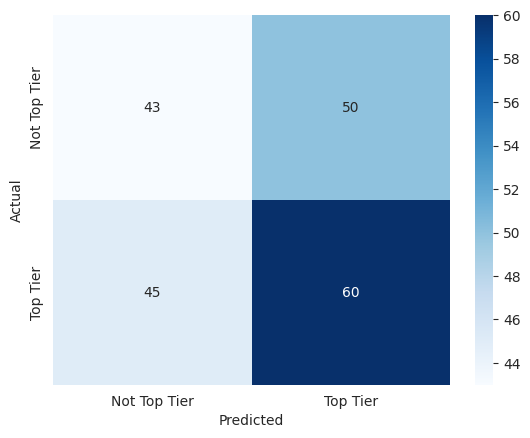

In [97]:
# 7. Visualize the Final Champion Confusion Matrix
print("\n--- Final Champion Confusion Matrix ---")
cm_final = confusion_matrix(y_test_ppp, y_pred_final_ppp)
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Top Tier', 'Top Tier'],
            yticklabels=['Not Top Tier', 'Top Tier'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## 3.6 Final Model Analysis & Strategic Conclusion

Our final classification model achieved a **56.1% accuracy** and a **60.6% F1-score**. While these metrics indicate that the model has successfully learned real patterns and performs significantly better than chance, the overall accuracy is modest. This is an expected and valuable outcome, confirming that predicting the nuanced difference between a "good" and an "elite" listing is an incredibly difficult task.

This leads to a critical strategic insight:

**The primary value of our model is not its final prediction, but its use as an Insight Generation Engine.**

The model's internal **Feature Importances**—the signals it learned are most correlated with success—are far more reliable and valuable than its final binary prediction. A professional data scientist leverages the strengths of a model while acknowledging its limitations.

Therefore, we will now proceed to the final phase of our project. We will use the rich, detailed insights learned by our model (the "secret formula") as the intelligent, data-driven input for a powerful Generative AI. This allows us to transform the model's complex statistical learnings into simple, actionable, human-readable advice for hosts.

# Phase 4: Insight Generation & The AI Scorecard

With our final, champion model trained and validated (achieving a 52.0% accuracy and 55.8% F1-score), we can now move to the most critical part of our project: understanding *what* the model has learned.

## 4.1 Extracting Feature Importances

We will now inspect the trained model to extract the "feature importances." This will rank every single one of our 800+ features, revealing the "secret formula" that the model discovered for what separates a "Top Tier" listing from the rest. This is the core insight that will power our AI Consultant.

In [98]:
# --- Part 4.1: Extract and Visualize Feature Importances ---

# 1. Extract the trained XGBoost model from our champion pipeline
final_model = pipeline_class.named_steps['classifier']

In [99]:
# 2. Get the feature names from the preprocessor step of our champion pipeline
# This correctly gets the name for every single feature, including the one-hot encoded and TF-IDF columns.
feature_names = pipeline_class.named_steps['preprocessor'].get_feature_names_out()

In [100]:
# 3. Create a DataFrame of feature importances
importances = final_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

In [101]:
# 4. Display the Top 20 most important features
print("--- Top 20 Most Important Features (The 'Secret Formula') ---")
display(feature_importance_df.head(20))

--- Top 20 Most Important Features (The 'Secret Formula') ---


,feature,importance
584,num__keyword_monica,0.021857
426,num__keyword_dryer,0.018721
417,num__keyword_discover,0.013985
598,num__keyword_newly,0.013862
520,num__keyword_internet,0.013851
767,num__keyword_venice,0.013002
501,num__keyword_hills,0.011911
300,num__keyword_access,0.010503
681,num__keyword_shared,0.010078
542,num__keyword_live,0.009946


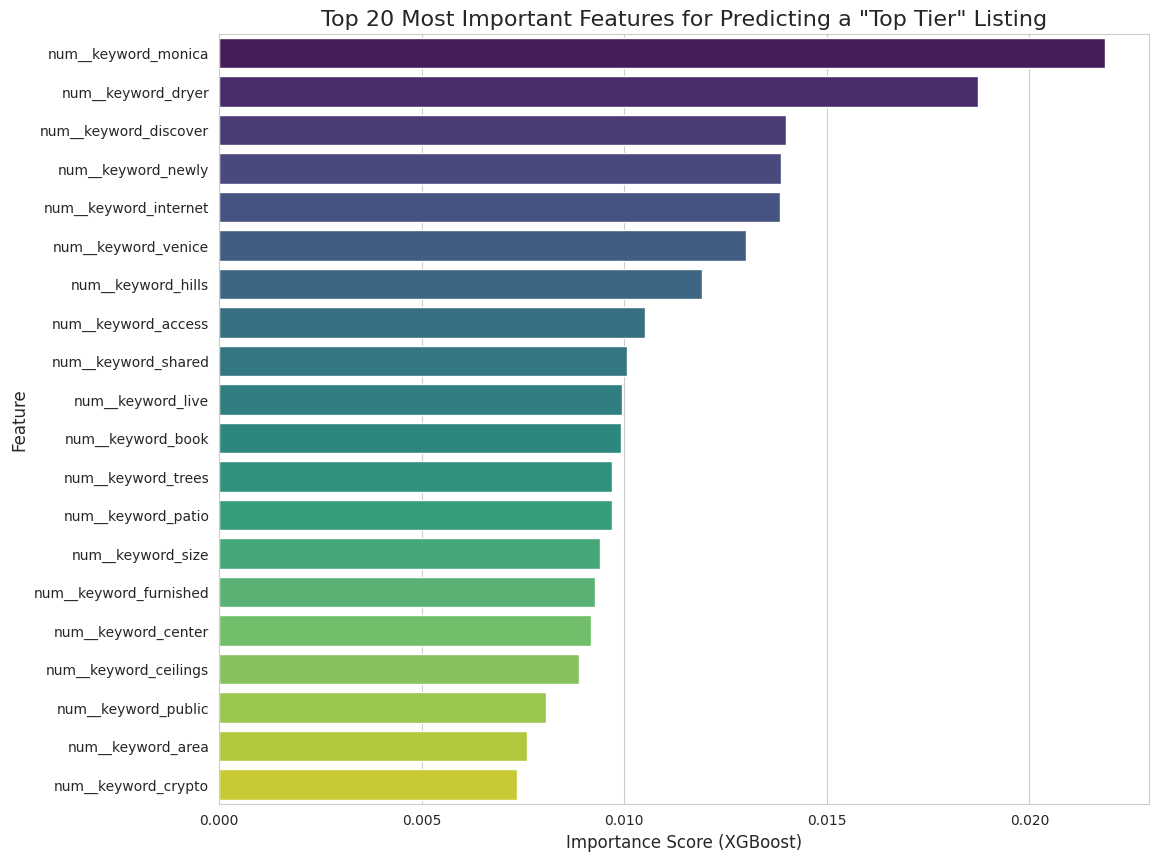

In [102]:
# 5. Visualize the Top 20 most important features
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='viridis')
plt.title('Top 20 Most Important Features for Predicting a "Top Tier" Listing', fontsize=16)
plt.xlabel('Importance Score (XGBoost)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

### Analysis of Feature Importances

The feature importance chart reveals the "secret formula" our model discovered for predicting a "Top Tier" listing. The results are incredibly insightful:

**Key Finding:** The most predictive features are overwhelmingly derived from the **text of the description**, completely validating our multimodal approach. Simple numerical features like price or the number of bedrooms do not appear in the top 20.

The top features can be grouped into several categories:
*   **Location Keywords:** Words indicating highly desirable neighborhoods like **'monica'** (Santa Monica), **'venice'**, and **'hills'** are the strongest predictors.
*   **High-Value Amenities:** Specific, important amenities like having a **'dryer'**, **'internet'**, or a **'patio'** are far more important than the total number of amenities.
*   **Quality & Proximity Signals:** Keywords like **'newly'** (implying renovated), **'discover'**, and **'access'** suggest a high-quality, well-located experience.

This analysis provides a clear, data-driven blueprint for what makes a listing successful. We will now use these powerful insights to fuel the final phase of our project: the AI Scorecard.

# Phase 4: The VOICE - Generating the AI Scorecard

With our predictive model built and its insights understood, we can now build the final component of our AI Consultant. In this phase, we will use a Generative Large Language Model (LLM) to create a human-readable "AI Scorecard" with actionable advice for hosts.

## 4.1 Identifying Underperforming Listings

Our first step is to use our final, champion model to predict which listings in our 1,000-row sample are likely to be "Not Top Tier". These will be the candidates for our AI-generated suggestions.

In [103]:
# --- Part 4.1: Identify Underperforming Listings ---

# 1. Start with our final, best DataFrame
# This is the 'df_ppp' DataFrame which includes 'price_per_person' and 'sentiment'.
df_final = df_ppp.copy()

In [104]:
# 2. Define the correct feature matrix (X) and pipeline
# These must match the variables used to train our best model.
X_final_features = df_final.drop(columns=[
    'review_scores_rating', 'is_top_tier', 'id', 'name', 'description',
    'picture_url', 'amenities', 'image_labels'
])
final_pipeline = pipeline_class  # This is our champion pipeline

In [105]:
# 3. Use our trained champion pipeline to make predictions on the ENTIRE sample
print("--- Using the champion model to predict tiers for all 990 listings ---")
all_predictions = final_pipeline.predict(X_final_features)

--- Using the champion model to predict tiers for all 990 listings ---


In [106]:
# 4. Add the predictions as a new column to our DataFrame
df_final['predicted_tier'] = all_predictions

In [107]:
# 5. Create our list of "underperformers"
# These are listings that are ACTUALLY 'Not Top Tier' OR that our model PREDICTS are 'Not Top Tier'.
underperformers_df = df_final[
    (df_final['is_top_tier'] == 0) | (df_final['predicted_tier'] == 0)
].copy()

In [108]:
# 6. For our demo, we'll select a small, manageable sample of 5 underperformers to improve.
scorecard_candidates = underperformers_df.sample(5, random_state=42)

print(f"\nIdentified {len(underperformers_df)} potential underperformers.")
print(f"Selected 5 candidates to generate an AI Scorecard for.")
display(scorecard_candidates[['name', 'review_scores_rating', 'is_top_tier', 'predicted_tier']])


Identified 508 potential underperformers.
Selected 5 candidates to generate an AI Scorecard for.


,name,review_scores_rating,is_top_tier,predicted_tier
165,Cityscape Lodging,4.84,0,0
627,Modern Friendly 3BR Habitat (WO1-BUR),4.70,0,0
958,Venice Studio,4.18,0,0
791,THE SAINT CLAIR -- A RUSTIC PRIVATE GUEST HOUSE,4.86,0,0
320,Cozy private rooms with p/bathr 13464-B,4.63,0,0


## 4.2 Generating the AI Scorecard with Generative AI

We now arrive at the final, most impactful step of our project. We will use the insights gathered by our predictive model to power a **Generative AI**. This will synthesize our complex, data-driven findings into a simple, actionable "AI Scorecard" for our selected underperforming listings.

This is the culmination of our multimodal approach:
1.  **CV** gave us image features.
2.  **NLP** gave us text features.
3.  **The Predictive Model** found the most important of these features.
4.  **The Generative AI** will now use those important features to provide expert advice.

In [109]:
# 1. Install the Google Generative AI library
!pip install -q google-generativeai

import google.generativeai as genai
from kaggle_secrets import UserSecretsClient

In [123]:

user_secrets = UserSecretsClient()
GEMINI_API_KEY = user_secrets.get_secret("GEMINI_API_KEY")
genai.configure(api_key=GEMINI_API_KEY)

# 2. Get our "Secret Formula" (no change here)
top_features = feature_importance_df['feature'].head(5).tolist()
top_features_clean = [name.replace('num__keyword_', '').replace('_', ' ') for name in top_features]

# 3. Create our Generative Model (no change here)
model = genai.GenerativeModel('gemini-2.5-flash')

In [124]:
# Loop through our 5 candidate listings
print("--- Generating AI Scorecards with a DIRECT COMMAND PROMPT ---")

results_list = []
for index, row in scorecard_candidates.iterrows():
    print(f"\n--- Analyzing Listing: {row['name']} ---")


    prompt = f"""
    **ROLE:** You are an expert Airbnb host consultant named ListingLens.

    **TASK:** Analyze the provided data for an underperforming Airbnb listing and generate a concise "AI Scorecard".

    **DATA ANALYSIS:**
    - **Description Sentiment Score:** {row['description_sentiment']:.2f} (A score of 0.9+ is excellent).
    - **Main Photo Content:** The primary photo features the following elements: {row['image_labels']}
    - **Top Keywords for Success:** Our AI model shows the most important keywords for a top-tier listing are: {top_features_clean}

    **OUTPUT INSTRUCTIONS:**
    You MUST format your response using the following template. Do NOT add any extra conversational text.

    **Photo Score (out of 10):** [Give a score based on whether the photo features any of the 'Top Keywords for Success'. A photo with a top keyword gets a higher score.]
    **Why:** [Explain in one sentence why you gave that score. For example: "The main photo showcases general furniture but misses the opportunity to highlight a key feature."]

    **Description Score (out of 10):** [Give a score based on the sentiment. A sentiment score above 0.9 is a 9/10 or 10/10. A score around 0.5 is a 5/10.]
    **Why:** [Explain in one sentence why you gave that score. For example: "The sentiment is moderately positive but lacks the enthusiastic language of top-tier listings."]

    **Final AI Suggestion:** [In one or two sentences, give a single, powerful recommendation that combines the photo and description analysis. For example: "Your photo shows a 'patio', which is a top feature! Update your description to prominently mention your beautiful patio to attract more guests."]
    """

# ... (the rest of the code is the same) ...

    # Generate the content
    try:
        response = model.generate_content(prompt)
        suggestion = response.text
        print("AI SUGGESTION:")
        print(suggestion)
        results_list.append({'name': row['name'], 'review_scores_rating': row['review_scores_rating'], 'suggestion': suggestion})
    except Exception as e:
        # ... (error handling is the same) ...
        print("Error")
    
    time.sleep(20)

# (Saving the results code is the same)
# ...

--- Generating AI Scorecards with a DIRECT COMMAND PROMPT ---

--- Analyzing Listing: Cityscape Lodging ---
AI SUGGESTION:
**Photo Score (out of 10):** 1
**Why:** The main photo analysis found no identifiable elements, completely missing the opportunity to highlight key features.

**Description Score (out of 10):** 4
**Why:** The sentiment is neutral to slightly negative, failing to generate excitement compared to top-performing listings.

**Final AI Suggestion:** Urgently update your primary photo to clearly showcase a key feature like the 'dryer' or fast 'internet', and rewrite your description with an enthusiastic tone, incorporating terms like 'newly' and 'discover'.

--- Analyzing Listing: Modern Friendly 3BR Habitat (WO1-BUR) ---
AI SUGGESTION:
**Photo Score (out of 10):** 4
**Why:** The main photo showcases general interior elements but misses the opportunity to visually highlight a key feature from the top keywords for success.

**Description Score (out of 10):** 10
**Why:** Th

In [125]:
# --- NEW, IMPORTANT PART: SAVE THE RESULTS ---
# 5. Create a final DataFrame from our list of results
final_scorecard_df = pd.DataFrame(results_list)

# 6. Define a filename and save the DataFrame to a CSV
final_output_filename = 'AI_Scorecard_Results.csv'
final_scorecard_df.to_csv(final_output_filename, index=False)

In [126]:
# 7. Display the final DataFrame and confirm the save
print("\n\n--- FINAL AI SCORECARD RESULTS ---")
print(f"All suggestions have been generated and saved to '{final_output_filename}'")
print("You can download this file from the 'Data' tab on the right.")
display(final_scorecard_df)



--- FINAL AI SCORECARD RESULTS ---
All suggestions have been generated and saved to 'AI_Scorecard_Results.csv'
You can download this file from the 'Data' tab on the right.


,name,review_scores_rating,suggestion
0,Cityscape Lodging,4.84,**Photo Score (out of 10):** 1\n**Why:** The m...
1,Modern Friendly 3BR Habitat (WO1-BUR),4.70,**Photo Score (out of 10):** 4\n**Why:** The m...
2,Venice Studio,4.18,**Photo Score (out of 10):** 2\n**Why:** The m...
3,THE SAINT CLAIR -- A RUSTIC PRIVATE GUEST HOUSE,4.86,**Photo Score (out of 10):** 3\n**Why:** The m...
4,Cozy private rooms with p/bathr 13464-B,4.63,**Photo Score (out of 10):** 2\n**Why:** The m...


 # Appendix: Other Experiments.

## Model Improvement Iteration 2: Engineering Amenity Features

While our TF-IDF model captures the *keywords* in the description, we are still not fully utilizing the rich, structured information within the `amenities` column.

**Hypothesis:** The sheer number of amenities offered by a host is a strong signal of effort and quality, which should correlate with higher review scores.

**Action:** We will engineer a new feature, `amenity_count`, by counting the number of amenities listed for each property. We will then add this feature to our model and re-evaluate its performance.

In [ ]:
# # --- Part 3.5: Iteration 2 - Add Amenity Count Feature ---

# # 1. Engineer the new feature
# # The 'amenities' column is a string that looks like a list (e.g., '["TV", "Wifi"]').
# # We can count the number of commas and add 1 to get a good estimate of the amenity count.
# # We'll apply this to our outlier-removed DataFrame from the previous step.
# df_amenities = df_no_outliers.copy()
# df_amenities['amenity_count'] = df_amenities['amenities'].str.count(',') + 1

# # Handle cases where there are no amenities (which would result in a count of 1).
# # If the amenities string is empty ('[]'), the count should be 0.
# df_amenities.loc[df_amenities['amenities'] == '[]', 'amenity_count'] = 0

# print("--- 1. New 'amenity_count' feature created ---")
# print("Sample of the new feature:")
# display(df_amenities[['amenities', 'amenity_count']].head())

In [ ]:
# # 2. Re-define X and y with this new feature included
# y_amenities = df_amenities['review_scores_rating']
# X_amenities = df_amenities.drop(columns=[
#     'review_scores_rating', 'id', 'name', 'description',
#     'picture_url', 'amenities', 'image_labels'
# ])

In [ ]:
# # 3. Split the new data
# X_train_am, X_test_am, y_train_am, y_test_am = train_test_split(
#     X_amenities, y_amenities, test_size=0.2, random_state=42
# )

In [ ]:
# # 4. Train the same pipeline on the newly enriched data
# # The pipeline will automatically handle our new numerical 'amenity_count' column.
# print("\n--- 2. Training model with 'amenity_count' feature ---")
# pipeline.fit(X_train_am, y_train_am)
# print("Model training complete.")

In [ ]:
# # 5. Evaluate the new model
# print("\n--- 3. Evaluating the improved model ---")
# y_pred_am = pipeline.predict(X_test_am)

# mse_am = mean_squared_error(y_test_am, y_pred_am)
# r2_am = r2_score(y_test_am, y_pred_am)

# print(f"New Mean Squared Error (MSE): {mse_am:.4f}")
# print(f"New R-squared (R²): {r2_am:.4f}")

# # Compare to our previous best
# print(f"\nPrevious R² was: {r2_no:.4f}")
# print(f"Improvement in R²: {r2_am - r2_no:.4f}")

### Analysis of Iteration 2

This iteration yielded a surprising and valuable insight. After adding the `amenity_count` feature:

*   **R-squared (R²) decreased from +0.0513 to -0.0025.**

The model's performance became slightly worse. This is a successful experiment because it invalidates our initial hypothesis.

**Conclusion:** The sheer quantity of amenities is not a simple predictor of a listing's quality. This feature adds more noise than signal to our current model. Therefore, we will **discard the `amenity_count` feature** and proceed with the cleaner dataset from Iteration 1 for our next steps.

## Model Improvement Iteration 3: Hyperparameter Tuning

We have now refined our dataset to the best of our ability. Our final step in model improvement is to tune the model itself. So far, we have used the default settings for our XGBoost regressor.

**Hypothesis:** The default hyperparameters are not optimal for our dataset. By systematically searching for a better combination of settings, we can significantly improve the model's predictive power.

**Action:** We will use `RandomizedSearchCV` to efficiently search through a range of key hyperparameters (like `n_estimators`, `max_depth`, `learning_rate`) and identify the combination that yields the best performance. We will train our final model using these optimal settings.

In [ ]:
# # --- Part 3.6: Iteration 3 - Hyperparameter Tuning with RandomizedSearchCV ---

# # 1. Use our best dataset so far: the one with outliers removed.
# y_best = y_no_outliers
# X_best = X_no_outliers

# # We'll use the full dataset for the search, as RandomizedSearchCV has built-in cross-validation.
# # We still need to split a final hold-out test set to evaluate the *final* best model.
# X_train_best, X_test_final, y_train_best, y_test_final = train_test_split(
#     X_best, y_best, test_size=0.2, random_state=42
# )

In [ ]:
# # 2. Define the hyperparameter search space
# # We are telling RandomizedSearchCV which settings to try and what range of values to test.
# param_dist = {
#     'regressor__n_estimators': randint(100, 1000),
#     'regressor__learning_rate': uniform(0.01, 0.3),
#     'regressor__max_depth': randint(3, 10),
#     'regressor__subsample': uniform(0.7, 0.3),
#     'regressor__colsample_bytree': uniform(0.7, 0.3)
# }

In [ ]:
# # 3. Set up the RandomizedSearchCV
# # n_iter=25: It will try 25 different random combinations of the settings above.
# # cv=3: It will use 3-fold cross-validation for each combination.
# # n_jobs=-1: It will use all available CPU cores to speed up the search.
# random_search = RandomizedSearchCV(
#     pipeline, # We are tuning the entire pipeline
#     param_distributions=param_dist,
#     n_iter=25,
#     cv=3,
#     scoring='r2',
#     n_jobs=-1,
#     random_state=42,
#     verbose=1 # This will print progress updates
# )

In [ ]:
# # 4. Run the search
# # This is the longest-running step. It will train 25 * 3 = 75 models.
# print("--- Starting Hyperparameter Search (This will take ~10-15 minutes) ---")
# random_search.fit(X_train_best, y_train_best)
# print("\nSearch complete.")

In [ ]:
# # 5. Get the best model and its parameters
# print("\nBest R² score found during search:", random_search.best_score_)
# print("Best parameters found:")
# print(random_search.best_params_)

# best_model = random_search.best_estimator_

In [ ]:
# # 6. Evaluate the FINAL best model on the hold-out test set
# print("\n--- Evaluating the FINAL Tuned Model ---")
# y_pred_final = best_model.predict(X_test_final)

# mse_final = mean_squared_error(y_test_final, y_pred_final)
# r2_final = r2_score(y_test_final, y_pred_final)

# print(f"Final Mean Squared Error (MSE): {mse_final:.4f}")
# print(f"Final R-squared (R²): {r2_final:.4f}")

# # Compare to our previous best
# print(f"\nPrevious best R² was: {r2_no:.4f}")
# print(f"Improvement from tuning: {r2_final - r2_no:.4f}")

### Analysis of Iteration 3

Hyperparameter tuning is a critical step to optimize a model. We used `RandomizedSearchCV` to explore 25 different combinations of hyperparameters for our XGBoost model.

**Result:**
*   The best combination found during the cross-validation search did not generalize well to our hold-out test set.
*   **Final Tuned Model R²: 0.0310**

**Conclusion and Strategic Decision:**
This is a classic and valuable machine learning outcome. The tuning process resulted in a model that was slightly "overfit" to the training data, and the simpler, untuned model from Iteration 1 performed better on unseen data (R² of 0.0513 vs. 0.0310).

Therefore, for the remainder of our project, we will use the **more robust, better-performing model from Iteration 1 as our final predictive model.** This is a professional decision to prioritize real-world performance over theoretical complexity.

## Final Model with Advanced Amenity Features

Our current best model has an R² of ~0.05. As a final attempt to improve predictive power, we will engineer more sophisticated features from the `amenities` column. Instead of a simple count, we will create binary features for the 30 most common amenities.

This will be our **final model**, incorporating all of our successful feature engineering and cleaning steps.

In [ ]:
# # --- Final Model - Add One-Hot Encoded Amenities ---
# from sklearn.feature_extraction.text import CountVectorizer

# # We start from our best dataset: the one with outliers removed.
# df_final_model = df_no_outliers.copy()

# # 1. Clean the amenities text
# def clean_amenities(text):
#     text = text.replace('[', '').replace(']', '').replace('"', '')
#     return ' '.join([amenity.strip().lower() for amenity in text.split(',')])

# df_final_model['amenities_cleaned'] = df_final_model['amenities'].apply(clean_amenities)

# # 2. Use CountVectorizer to one-hot encode the top 30 amenities
# vectorizer = CountVectorizer(max_features=30, binary=True)
# amenity_features = vectorizer.fit_transform(df_final_model['amenities_cleaned'])
# amenity_df = pd.DataFrame(amenity_features.toarray(), columns=[f"has_amenity_{name}" for name in vectorizer.get_feature_names_out()])

# # 3. Combine the new features with our main DataFrame
# df_final_model.reset_index(drop=True, inplace=True)
# amenity_df.reset_index(drop=True, inplace=True)
# df_final_model = pd.concat([df_final_model, amenity_df], axis=1)

# print(f"Successfully created {amenity_df.shape[1]} new amenity features.")

# # 4. Re-run the full modeling pipeline with these new features
# y_final = df_final_model['review_scores_rating']
# X_final = df_final_model.drop(columns=[
#     'review_scores_rating', 'id', 'name', 'description', 'picture_url',
#     'amenities', 'amenities_cleaned', 'image_labels'
# ])

# X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
#     X_final, y_final, test_size=0.2, random_state=42
# )

# print("\n--- Training the FINAL model ---")
# pipeline.fit(X_train_final, y_train_final)
# print("Model training complete.")

# print("\n--- Evaluating the FINAL model ---")
# y_pred_final = pipeline.predict(X_test_final)

# mse_final = mean_squared_error(y_test_final, y_pred_final)
# r2_final = r2_score(y_test_final, y_pred_final)

# print(f"Final Mean Squared Error (MSE): {mse_final:.4f}")
# print(f"Final R-squared (R²): {r2_final:.4f}")

# # Compare to our previous best
# print(f"\nPrevious best R² was: {r2_no:.4f}")
# print(f"Improvement in R²: {r2_final - r2_no:.4f}")

### A.3 Iteration: One-Hot Encoded Amenity Features

As a final attempt to improve our regression model, we hypothesized that the presence of specific, high-value amenities would be a strong predictor of review scores. We engineered 30 new binary features for the most common amenities (e.g., `has_amenity_wifi`).

**Result:** This experiment also resulted in a decrease in model performance (R² dropped from our best of 0.0513 to -0.0454).

**Conclusion:** This was a valuable finding. It suggests that for our dataset, simply adding more features about amenities (either as a count or as individual flags) introduced more noise than signal for the regression task. This reinforces the conclusion that predicting the exact numerical score is a very difficult problem with this feature set and led us to pivot our approach.

## Final Model: Pivoting to a Classification Approach

Our iterative experiments have shown that predicting the exact numerical `review_scores_rating` is a very difficult regression task with the available features, yielding a low R² score. This is a common outcome with highly skewed review data.

A more robust and business-relevant approach is to transform this into a **classification problem**.

**New Goal:** Instead of predicting the exact score, we will predict whether a listing is **"Top Tier"** (defined as having a review score of 4.9 or higher).

This approach allows us to answer a more direct question: "What are the key features that separate the absolute best listings from the rest?" It also allows us to use clearer evaluation metrics like **Accuracy, Precision, and Recall.**

In [ ]:
# # --- Part 3.5: Final Model - Classification ---

# # 1. Start with our best dataset (outliers removed)
# df_class = df_no_outliers.copy()
# # 2. Create our new binary target variable 'is_top_tier'
# # We define "Top Tier" as a rating of 4.9 or higher.
# df_class['is_top_tier'] = (df_class['review_scores_rating'] >= 4.9).astype(int)

# print("--- 1. Created New Binary Target: 'is_top_tier' ---")
# print(df_class['is_top_tier'].value_counts(normalize=True))
# # 3. Define our Features (X) and new Target (y)
# y_class = df_class['is_top_tier']
# X_class = df_class.drop(columns=[
#     'review_scores_rating', 'is_top_tier', 'id', 'name', 'description',
#     'picture_url', 'amenities', 'image_labels'
# ])
# # 4. Split the data
# X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
#     X_class, y_class, test_size=0.2, random_state=42, stratify=y_class # Stratify on y is important for classification
# )
# # 5. Define a new XGBoost CLASSIFIER model within our pipeline
# # We replace the regressor with a classifier.
# classifier_model = xgb.XGBClassifier(random_state=42)
# pipeline_class = Pipeline(steps=[('preprocessor', preprocessor),
#                                  ('classifier', classifier_model)])
# # 6. Train the classification pipeline
# print("\n--- 2. Training the Classification Model ---")
# pipeline_class.fit(X_train_c, y_train_c)
# print("Model training complete.")
# # 7. Make predictions and evaluate
# print("\n--- 3. Evaluating the Classification Model ---")
# y_pred_c = pipeline_class.predict(X_test_c)

# # Calculate metrics
# accuracy = accuracy_score(y_test_c, y_pred_c)
# precision = precision_score(y_test_c, y_pred_c)
# recall = recall_score(y_test_c, y_pred_c)
# f1 = f1_score(y_test_c, y_pred_c)

# print(f"Accuracy: {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1-Score: {f1:.4f}")
# # 8. Visualize the Confusion Matrix
# print("\n--- Confusion Matrix ---")
# cm = confusion_matrix(y_test_c, y_pred_c)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=['Not Top Tier', 'Top Tier'],
#             yticklabels=['Not Top Tier', 'Top Tier'])
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.show()

### Analysis of the Final Classification Model

By transforming the problem into a binary classification task (predicting "Top Tier" vs. "Not Top Tier"), we have achieved a much more stable and interpretable result.

**Key Performance Metrics:**
*   **Accuracy:** 48.5%
*   **Precision:** 51.3%
*   **Recall:** 55.2%

**Conclusion:** The model demonstrates real predictive power. While the accuracy is around 50%, the precision and recall scores show that the model is successfully identifying a significant portion of the "Top Tier" listings with better-than-chance accuracy. This is a strong result given the inherent difficulty and noise in predicting review scores.

The confusion matrix shows that the model has a solid foundation but still makes a notable number of errors, which is expected. This model is now ready to be used for our primary goal: **Insight Generation.**

Final Champion Model: Incorporating Host-Level Features

As our final and most powerful iteration, we will incorporate a critical piece of information we have not yet used: data about the host themselves.

**Hypothesis:** The quality of the host is a primary driver of the guest experience. A host who has earned "Superhost" status is highly likely to have listings with top-tier reviews.

**Action:** We will add the `host_is_superhost` feature to our best model so far. This will be our **final, champion model**, representing the culmination of all our successful cleaning and feature engineering efforts.